# Python for Data Analysis using Pandas  (part 2 of 2)

> The latest version of this notebook is always found at [github.com/tommyod/awesome-pandas](https://github.com/tommyod/awesome-pandas).   
  Improvements, corrections or suggestions? **Please submit a [Pull Request](https://github.com/tommyod/awesome-pandas/pulls).**

# Table of contents

- **(5) Filtering and sorting**
  - (5.1) Equality, non-equality and logical operators
  - (5.2) Group membership and string filtering
- **(6) Split-apply-combine and pivots**
  - (6.1) The groupby operation
  - (6.2) Several groups and aggregations
  - (6.3) Unstacking and stacking
  - (6.4) Pivoting and melting
  - (6.4) Merging
- **(7) Plotting**
  - (7.1) Built-in `plot()` methods
  - (7.2) Using matplotlib
- **(8) Time series manipulations**
  - (8.1) `.dt` accessor
  - (8.2) Rolling window functions
  - (8.3) Resampling
- **(9) Modeling and Machine Learning**
  - (9.1) Dummy variables for categorical data
  - (9.2) Training a model
- **(10) Misc tips and tricks**
  - (10.1) Performance
  - (10.2) Exporting data

---------------------------------

# (1) Setup

## (1.1) Installing Python and packages

### Python and Anaconda

If you haven't done it yet, you need to install Python.
I recommend the [Anaconda Distribution](https://www.anaconda.com/download/), and you should install version `3.X`.
- If you're on Windows, you will get a program called *Anaconda Prompt*. Open in and run `conda --version` to verify that everything works.
- If you're on Linux, open a terminal and run `conda --version`.

Type `conda list` to see every installed package, and `conda update --all` to update every package. Type `python` to open an interactive Python terminal, and `exit()` to leave.

## (1.2) Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import KDEpy
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

### Package versions

To make this Jupyter Notebook reproducible, we list versions of the libraries we will be using.

In [2]:
import datetime

print('Today is', datetime.datetime.utcnow())
print('-'*2**6)

for lib in [pd, np, matplotlib, KDEpy, sklearn]:
    print(f'{lib.__name__.ljust(12)} version {lib.__version__}')

Today is 2019-03-11 12:24:04.996909
----------------------------------------------------------------
pandas       version 0.24.1
numpy        version 1.15.4
matplotlib   version 3.0.2
KDEpy        version 0.6.11
sklearn      version 0.20.1


# (2) Importing data

## (2.1) Importing `.csv` files

In [3]:
%%time

cols_to_use = ['movie_title', 'director_name', 'country', 'content_rating', 'imdb_score', 'gross']
df = pd.read_csv(r'data/movie_metadata.csv', sep=',', usecols=cols_to_use)
print(f'Loaded data of size {df.shape} into memory.')

df = df.dropna(axis=0, how='any').drop_duplicates(subset=None)

Loaded data of size (5043, 6) into memory.
CPU times: user 68.6 ms, sys: 12.7 ms, total: 81.3 ms
Wall time: 235 ms


**Reading a HTML table from the web**

In [4]:
# Read HTML tables into a list of DataFrame objects.
url = r'https://en.wikipedia.org/wiki/List_of_Germans_by_net_worth'
tables = pd.read_html(url, header=0)

df_net_worth = tables[0]

# Asserts can be useful for sanity checks
assert len(df_net_worth) > 0 
assert df_net_worth.Name.is_unique


df_net_worth.head()

,World ranking,Name,Citizenship,Net worth (USD),Sources of wealth
0,21,Georg Schaeffler,Germany,26.9 billion,Schaeffler Group
1,37,Beate Heister (b. Albrecht) & Karl Albrecht Jr.,Germany,21.3 billion,Aldi Süd
2,46,Dieter Schwarz,Germany,19.4 billion,Schwarz Gruppe
3,49,Theo Albrecht Jr.,Germany,19 billion,Aldi Nord and Trader Joe's
4,50,Michael Otto,Germany,18.1 billion,Otto Group


## (2.3) Changing names and data types

In [5]:
# Alter axes labels
df_net_worth = (df_net_worth
                .rename(columns={'Net worth (USD)': 'net_worth',
                                'World ranking': 'world_ranking',
                                'Sources of wealth': 'wealth_source'}))

In [6]:
df_net_worth['net_worth_num'] = (df_net_worth['net_worth']
                             .str.replace(' billion', '')
                             .apply(float))

--------------

# (5) Filtering and sorting

We've already seen basic filtering. 

- `==` defines equality
- `!=` defines inquality equality
- `~` negates logic, e.g. `True` -> `False`
- `&` represents elementwise `and`
- `|` represents elementwise `or`

Remember to parenthesize expressions, write:

> `(df.col_A > 5) & (df.col_B <= 5)`



## (5.1) Equality, non-equality and logical operators

- When using the `df[array-like]` syntax, pandas is smart enough to figure out what you want. 
- For finer control, use the `df.loc[[row1, row2, ...], [col1, col2, ...]]` syntax instead.

Below we create boolean vectors over the rows (*masks*) and select based on these.

In [7]:
df[['gross', 'movie_title']].head()  # Selects columns

# Select when the row numbers is divisible by 11
# The actual df.index need not be numeric here
mask = np.where(df.index % 11 == 0, True, False)
df.set_index('movie_title')[mask].head()  # Selects rows

# Here the index needs to be numeric, to match the mask
mask = pd.Series(mask, index=df.index)
df[mask].head()

,director_name,gross,movie_title,country,content_rating,imdb_score
0,James Cameron,760505847.0,Avatar,USA,PG-13,7.9
11,Bryan Singer,200069408.0,Superman Returns,USA,PG-13,6.1
22,Ridley Scott,105219735.0,Robin Hood,USA,PG-13,6.7
33,Tim Burton,334185206.0,Alice in Wonderland,USA,PG,6.5
44,McG,125320003.0,Terminator Salvation,USA,PG-13,6.6


Here's how we apply the above to filter out rows.

In [8]:
# Movies and TV shows from Norway
df[df.country == 'Norway'].head(3)

,director_name,gross,movie_title,country,content_rating,imdb_score
3690,Morten Tyldum,1196752.0,Headhunters,Norway,R,7.6
4007,André Øvredal,252652.0,Trollhunter,Norway,PG-13,7.0
4240,Petter Næss,313436.0,Elling,Norway,R,7.6


In [9]:
mask = ((df.imdb_score > 8) & (df.country != 'USA') & (df.gross > 10**6))
df[mask].nlargest(3, columns=['imdb_score'])

,director_name,gross,movie_title,country,content_rating,imdb_score
4498,Sergio Leone,6100000.0,"The Good, the Bad and the Ugly",Italy,Approved,8.9
270,Peter Jackson,313837577.0,The Lord of the Rings: The Fellowship of the R...,New Zealand,PG-13,8.8
4029,Fernando Meirelles,7563397.0,City of God,Brazil,R,8.7


## (5.2) Group membership and string filtering

In [10]:
# Top three movies from Japan or Hong Kong
df[df.country.isin(['Japan', 'Hong Kong'])].nlargest(5, 'imdb_score')

,director_name,gross,movie_title,country,content_rating,imdb_score
4747,Akira Kurosawa,269061.0,Seven Samurai,Japan,Unrated,8.7
2373,Hayao Miyazaki,10049886.0,Spirited Away,Japan,PG,8.6
2323,Hayao Miyazaki,2298191.0,Princess Mononoke,Japan,PG-13,8.4
2047,Hayao Miyazaki,4710455.0,Howl's Moving Castle,Japan,PG,8.2
3423,Katsuhiro Ôtomo,439162.0,Akira,Japan,R,8.1


In [11]:
# Movies and TV shows NOT from scandinavia
df[~df.country.isin(['Norway, Sweden', 'Denmark'])].head(3)

,director_name,gross,movie_title,country,content_rating,imdb_score
0,James Cameron,760505847.0,Avatar,USA,PG-13,7.9
1,Gore Verbinski,309404152.0,Pirates of the Caribbean: At World's End,USA,PG-13,7.1
2,Sam Mendes,200074175.0,Spectre,UK,PG-13,6.8


In [12]:
# Contains the word 'lord'
mask = df.movie_title.str.lower().str.contains("lord")

 # Gross better than 25 % of the movies
mask = mask & (df.gross > df.gross.quantile(q=0.25))

df[mask]

,director_name,gross,movie_title,country,content_rating,imdb_score
270,Peter Jackson,313837577.0,The Lord of the Rings: The Fellowship of the R...,New Zealand,PG-13,8.8
339,Peter Jackson,377019252.0,The Lord of the Rings: The Return of the King,USA,PG-13,8.9
340,Peter Jackson,340478898.0,The Lord of the Rings: The Two Towers,USA,PG-13,8.7
1170,Andrew Niccol,24127895.0,Lord of War,USA,R,7.6
1974,Catherine Hardwicke,11008432.0,Lords of Dogtown,USA,PG-13,7.1


# (6) Split-apply-combine and pivots

## (6.1) The groupby operation

Very similar to Structured Query Language (SQL).

**SQL - [The SQL GROUP BY Statement](https://www.w3schools.com/sql/sql_groupby.asp)**

```sql
SELECT TOP 3 
    country, 
    AVG(imdb_score) as mean_imdb_score
FROM df
GROUP BY country; 
```

**Pandas - [Group By: split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)**

```python
df.groupby(df.country).mean().head(3)
```

![](https://data36.com/wp-content/uploads/2017/06/SQL-GROUP-BY-clause-768x540.png)

*Image source is https://data36.com/sql-functions-beginners-tutorial-ep3/*

**Example.** Mean `imdb_score` per country.

In [13]:
df[['country', 'imdb_score']].sample(4, random_state=1)

,country,imdb_score
3533,USA,6.0
4024,France,7.6
974,USA,5.8
4784,USA,6.2


In [14]:
df.groupby(df.country).mean().head(3)

,gross,imdb_score
country,,
Afghanistan,1.127331e+06,7.4
Argentina,7.230936e+06,7.6
Aruba,1.007614e+07,4.8


**Example.** Directors with the most movies.

In [15]:
top_n = 5  # Top people to show

(df
 .groupby(df.director_name)
 .nunique()
 .movie_title
 .nlargest(top_n)
 .to_frame()
)

,movie_title
director_name,
Steven Spielberg,25
Clint Eastwood,19
Woody Allen,19
Martin Scorsese,18
Ridley Scott,16


- `mean()` - Compute mean of groups
- `sum()` - Compute sum of group values
- `size()` - Compute group sizes
- `count()` - Compute count of group
- `std()` - Standard deviation of groups
- `var()` - Compute variance of groups
- `sem()` - Standard error of the mean of groups
- `describe()` - Generates descriptive statistics
- `first()` - Compute first of group values
- `last()` - Compute last of group values
- `nth()` - Take nth value, or a subset if n is a list
- `min()` - Compute min of group values
- `max()` - Compute max of group values

*The above is from the [pandas docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#aggregation).*

## (6.2) Several groups and aggregations

**Several groups (columns).** A group can be a combination of columns, e.g. [`country`, `content_rating`].

In [16]:
(df
 .groupby(['country', 'content_rating'])
 .mean()
 .imdb_score
 .round(2)
 .to_frame()
 .head(10)
)

imdb_score
country     content_rating            
Afghanistan PG-13                 7.40
Argentina   R                     7.60
Aruba       R                     4.80
Australia   G                     6.30
            PG                    6.20
            PG-13                 6.51
            R                     6.60
            Unrated               6.30
Belgium     R                     7.10
Brazil      R                     8.17

**Several aggregation functions.** Serveral aggregation functions may be used.   
Below we see directors and their `average`, `max` and `min` imdb_scores.

In [17]:
(df
 .groupby(df.director_name)
 .agg(['mean', 'min', 'max'])
 .imdb_score
 .head(2)
)

,mean,min,max
director_name,,,
Aaron Schneider,7.1,7.1,7.1
Aaron Seltzer,2.7,2.7,2.7


In [18]:
def spread(series):
    """Custom aggregation function."""
    return series.max()  - series.min()


(df
 .groupby(df.director_name)
 .agg(['mean', spread, 'nunique'])
 .imdb_score
 .loc[lambda df:df['nunique'] > 1, :]
 .head(2)
)

,mean,spread,nunique
director_name,,,
Adam McKay,6.916667,1.5,6
Adam Shankman,5.962500,2.2,7


**Several groups (columns) and aggregation functions.**

In [19]:
funcs = {'imdb_score': [pd.Series.mean, pd.Series.std], 'gross': [pd.Series.mean, pd.Series.max]}

df.groupby(['country', 'content_rating']).agg(funcs).head(15)

imdb_score                   gross             
                                 mean       std          mean          max
country     content_rating                                                
Afghanistan PG-13            7.400000       NaN  1.127331e+06    1127331.0
Argentina   R                7.600000  0.793725  7.230936e+06   20167424.0
Aruba       R                4.800000       NaN  1.007614e+07   10076136.0
Australia   G                6.300000  0.707107  4.245900e+07   66600000.0
            PG               6.200000  1.157584  5.703676e+07  257756197.0
            PG-13            6.511111  0.744050  5.468192e+07  174635000.0
            R                6.600000  0.824621  2.336834e+07  153629485.0
            Unrated          6.300000       NaN  2.651070e+05     265107.0
Belgium     R                7.100000       NaN  1.357042e+06    1357042.0
Brazil      R                8.175000  0.359398  3.385652e+06    7563397.0
            Unrated          6.100000       NaN  2.026200e+04      20262.0
Cameroon    Not Rated        7.500000       NaN  3.263100e+04      32631.0
Canada      G                2.800000       NaN  1.114452e+07   11144518.0
            Not Rated        6.475000  0.741058  1.831962e+05     703002.0
            PG               5.520000  1.023230  5.192535e+07  113006880.0

## (6.3) Unstacking and stacking

To motivate the methods, consider the following data set.

Data source: https://github.com/highcharts/highcharts/blob/master/samples/data/world-population-history.csv

In [20]:
df_world = pd.read_csv(f'data/world_population_history.csv')

In [21]:
drop_cols = ['Country Name', 'Country Code', 'Indicator Name', 
             'Indicator Code', 'World Development Indicators']

df_world = (df_world
            .drop(columns=drop_cols)
            .dropna(axis=1, how='all')
           )

In [22]:
df_world.head(5)

,Data Source,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,58386.0,58726.0,59063.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105000.0
1,Afghanistan,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,10604346.0,10854428.0,11126123.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530000.0
2,Angola,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,6523791.0,6642632.0,6776381.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784000.0
3,Albania,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,2022272.0,2081695.0,2135479.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2879000.0
4,Andorra,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,21890.0,23058.0,24276.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,77000.0


The dataset from [https://github.com/highcharts/highcharts](https://github.com/highcharts/highcharts/blob/master/samples/data/world-population-history.csv) is **not tidy**.

>  (1) Each variable you measure should be in one column.   
   (2) Each different observation of that variable should be in a different row.   
   (3) There should be one table for each "kind" of variable.   
   (4) If you have multiple tables, they should include a column in the table that allows them to be linked.
    



Read ["Tidy Data" by H Wickham](https://www.jstatsoft.org/article/view/v059i10/v59i10.pdf) for more information.

In [23]:
# We put the data in tidy format as follows

df_world_tidy = (df_world
 .set_index(['Data Source'])
 .stack(0)
 .rename('Population')
 .to_frame()
 .reset_index()
 .rename(columns={'level_1':'Year', 'Data Source':'Country'})
 .assign(Year=lambda df:pd.to_datetime(df.Year))
)

df_world_tidy.head(5)

,Country,Year,Population
0,Aruba,1960-01-01,56225.0
1,Aruba,1961-01-01,56695.0
2,Aruba,1962-01-01,57032.0
3,Aruba,1963-01-01,57360.0
4,Aruba,1964-01-01,57715.0


> **Note.** What does it mean to have tidy data in relational databases? Read about [Boyce–Codd normal form](https://en.wikipedia.org/wiki/Boyce%E2%80%93Codd_normal_form).

Plotting libraries might not want data in a tidy format. The following transformation is often required.

In [24]:
to_plot = (df_world_tidy
           .set_index(['Country', 'Year'])
           .unstack(level=0)
           .loc[:, (slice(None), ['Norway', 'Sweden'])]
          )

to_plot.head()

Population           
Country        Norway     Sweden
Year                            
1960-01-01  3638918.0  7561588.0
1961-01-01  3666537.0  7604328.0
1962-01-01  3694339.0  7661354.0
1963-01-01  3723168.0  7733853.0
1964-01-01  3753012.0  7807797.0

## (6.4) Pivoting and melting

We'll show how pivoting and meling can help us create data for plotting.

In [25]:
# The tidy data set
df_world_tidy.head(3)

,Country,Year,Population
0,Aruba,1960-01-01,56225.0
1,Aruba,1961-01-01,56695.0
2,Aruba,1962-01-01,57032.0


The `.pivot()` method is more powerful than unstack. Both move rows up to the columns.

In [26]:
# Demonstrating the pivot method
# Return reshaped DataFrame organized by given index / column values.
df_world_pivot = df_world_tidy.pivot(index='Year', columns='Country', values='Population')
df_world_pivot.iloc[:5, :5]

Country,Afghanistan,Albania,Algeria,American Samoa,Andorra
Year,,,,,
1960-01-01,9345868.0,1711319.0,11690153.0,21117.0,15370.0
1961-01-01,9533954.0,1762621.0,11985136.0,21882.0,16412.0
1962-01-01,9731361.0,1814135.0,12295970.0,22698.0,17469.0
1963-01-01,9938414.0,1864791.0,12626952.0,23520.0,18549.0
1964-01-01,10152331.0,1914573.0,12980267.0,24321.0,19647.0


In [27]:
# Drop every country where there are any missing values
df_world_pivot = df_world_pivot.dropna(how='any', axis=1)

In [28]:
# Compute the relative change since 1960
first_row = df_world_pivot.iloc[0, :]
df_world_rel = (df_world_pivot / first_row)
df_world_rel.iloc[:5, :5]

Country,Afghanistan,Albania,Algeria,American Samoa,Andorra
Year,,,,,
1960-01-01,1.000000,1.000000,1.000000,1.000000,1.000000
1961-01-01,1.020125,1.029978,1.025233,1.036227,1.067794
1962-01-01,1.041247,1.060080,1.051823,1.074869,1.136565
1963-01-01,1.063402,1.089681,1.080136,1.113795,1.206831
1964-01-01,1.086291,1.118770,1.110359,1.151726,1.278269


The `.melt()` method is more powerful than stack. Both move columns up to the index.

> `unstack` and `stack` are inverse operations.   
  `pivot` and `melt` are inverse operations.

In [29]:
# When pivoted, computing the relative change is easy
# Converting back to tidy format can be achieved using `melt`
df_world_rel = df_world_rel.reset_index().melt(id_vars='Year', value_name='Population')
df_world_rel.iloc[:5, :5]

,Year,Country,Population
0,1960-01-01,Afghanistan,1.000000
1,1961-01-01,Afghanistan,1.020125
2,1962-01-01,Afghanistan,1.041247
3,1963-01-01,Afghanistan,1.063402
4,1964-01-01,Afghanistan,1.086291


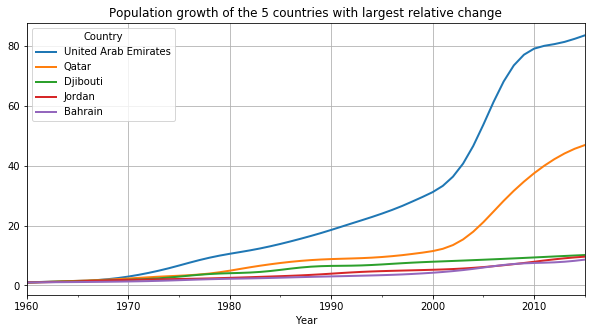

In [30]:
top_n = 5
plot_title = f'Population growth of the {top_n} countries with largest relative change'

# Countries with the largest relative change over time
countries = (df_world_rel
             .groupby('Country')
             .max()
             .Population
             .nlargest(top_n)
             .index
            )


# Plot the population of the above countries
(df_world_rel
 .pivot(index='Year', columns='Country', values='Population')
 .loc[:, countries]
 .plot(figsize=(10, 5), title=plot_title, grid=True, lw=2)
);

## (6.5) Merging

![](https://www.dofactory.com/Images/sql-joins.png)

*Image source is https://www.dofactory.com/sql/join*

> **Tip.** Learning SQL is likely worth your time, see for instance [w3schools.com](https://www.w3schools.com/sql/default.asp) and [sqlzoo.net](https://sqlzoo.net/wiki/SELECT_names).

Add a column showing every directors average imdb score.

In [31]:
director_means = (df
                  .groupby(df.director_name)
                  .mean()
                  .round(1)
                  .loc[:, ['imdb_score']]
                  .rename(columns={'imdb_score':'director_imdb_score'})
                 )
director_means.head(5)

,director_imdb_score
director_name,
Aaron Schneider,7.1
Aaron Seltzer,2.7
Abel Ferrara,6.6
Adam Brooks,7.2
Adam Goldberg,5.4


In [32]:
df.merge(director_means, how='left', left_on='director_name', right_index=True).head()

,director_name,gross,movie_title,country,content_rating,imdb_score,director_imdb_score
0,James Cameron,760505847.0,Avatar,USA,PG-13,7.9,7.9
1,Gore Verbinski,309404152.0,Pirates of the Caribbean: At World's End,USA,PG-13,7.1,7.0
2,Sam Mendes,200074175.0,Spectre,UK,PG-13,6.8,7.5
3,Christopher Nolan,448130642.0,The Dark Knight Rises,USA,PG-13,8.5,8.4
5,Andrew Stanton,73058679.0,John Carter,USA,PG-13,6.6,7.7


The inner join, or `merge(how='inner')` can be used if you want the intersection.

In [33]:
# For every director which has made movies in the USA and Cananda
# get average imdb scores for both locations

american_directors = (df[df.country == 'USA']
                      .groupby('director_name')
                      .mean().imdb_score.to_frame()
                     )
canadian_directors = (df[df.country == 'Canada']
                      .groupby('director_name')
                      .mean().imdb_score.to_frame()
                     )

(american_directors.merge(canadian_directors, how='inner', 
                          left_index=True, right_index=True, 
                          suffixes=('_USA', '_Canada'))
                   .round(1)
                   .head())

,imdb_score_USA,imdb_score_Canada
director_name,,
Adam Shankman,6.2,5.5
Andrzej Bartkowiak,5.8,3.7
Atom Egoyan,6.3,7.0
Bennett Miller,7.6,7.4
Bob Clark,2.5,6.2


For more information about mergning, see the [Pandas Merging 101](https://stackoverflow.com/questions/53645882/pandas-merging-101/53645883#53645883) question on stackoverflow.

# (7) Plotting

## (7.1) Built-in `plot()` methods


Excellent for creating plots quickly. The downside is less control.

The built in plot options are:

- `line` : line plot (default)
- `bar` : vertical bar plot
- `barh` : horizontal bar plot
- `hist` : histogram
- `box` : boxplot
- `kde` : Kernel Density Estimation plot
- `density` : same as ‘kde’
- `area` : area plot
- `pie` : pie plot
- `scatter` : scatter plot
- `hexbin` : hexbin plot



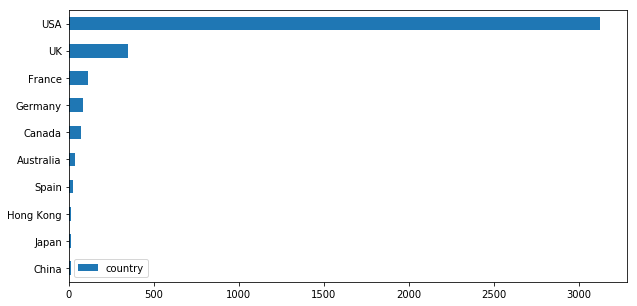

In [34]:
# Plot countries by number of occurences
(df.country
 .value_counts()
 .head(n=10)
 .sort_values(ascending=True)
 .to_frame()
 .plot.barh(figsize=(10, 5)));

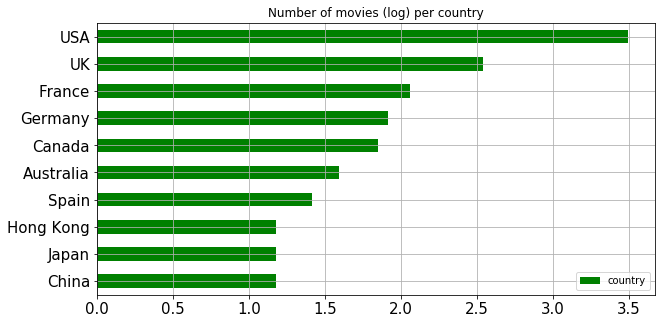

In [35]:
(df.country
 .value_counts()
 .head(n=10)
 .apply(np.log10)
 .sort_values(ascending=True)
 .to_frame()
 .plot.barh(grid=True, color='green', fontsize=15, 
            title='Number of movies (log) per country', figsize=(10, 5)));

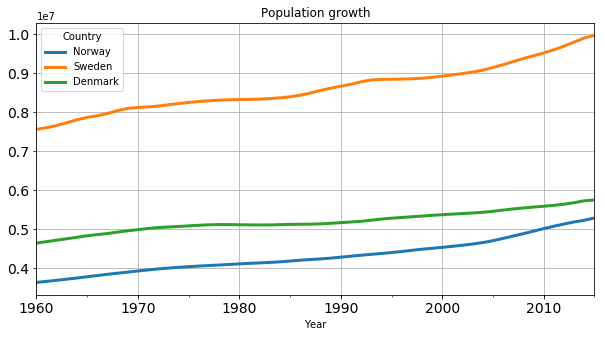

In [36]:
countries = set(['Norway', 'Sweden', 'Denmark'])
df_world_pivot.loc[:, countries].plot(linewidth=3, title='Population growth', 
                                      fontsize=14, figsize=(10, 5), grid=True);

## (7.2) Using matplotlib

Greater control. Allows creating of publication-quality plots.   
Does require more code and knowledge of matplotlib.

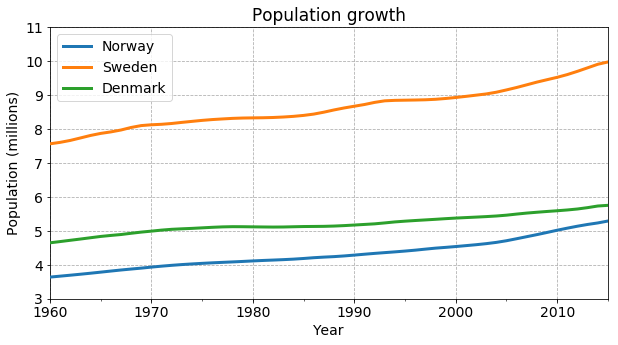

In [37]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5))

# Use the pandas plotting functionality, passing and returning the axis
ax = (df_world_pivot.loc[:, countries] / 10**6).plot(ax=ax, lw=3, zorder=50)

# Tweak the axis object to your desire
ax.set_title('Population growth', fontsize=17)
ax.legend(fontsize=14, loc='upper left')
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_ylabel('Population (millions)', fontsize=14)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
ax.grid(True, zorder=-50, ls='--')
ax.set_ylim([3, 11]);

# plt.savefig('my_figure.pdf')

Examine the distribution over the scores, unweighted and weighted by gross.   
Here we use [KDEpy](https://kdepy.readthedocs.io/en/latest/) to show how data can be sent from Pandas to other libraries.

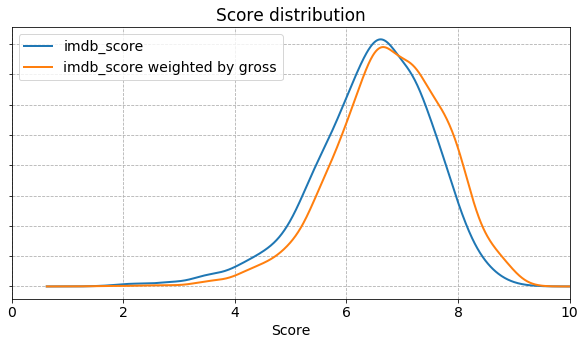

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))

# Compute kernel density estimates
from KDEpy import FFTKDE
data = df[['imdb_score', 'gross']].dropna(how='any')

kde = FFTKDE(bw='ISJ', kernel='gaussian')

# This is the crucial line: to_numpy() converts the column for us
x, y = kde.fit(data.imdb_score.to_numpy()).evaluate()
ax.plot(x, y, label='imdb_score', lw=2)

# Same idea here as above, we use to_numpy()
y = kde.fit(data.imdb_score.to_numpy(), 
            weights=data.gross.to_numpy()).evaluate(x)
ax.plot(x, y, label='imdb_score weighted by gross', lw=2)

ax.set_title('Score distribution', fontsize=17)
ax.legend(fontsize=14, loc='upper left')
ax.tick_params(axis='x', which='both', labelsize=14)
ax.set_yticklabels([])
ax.set_xlabel('Score', fontsize=14)
ax.grid(True, zorder=-50, ls='--')
ax.set_xlim([0, 10]);

#plt.savefig('my_figure.pdf')

For more information about plotting, see:

- [The matplotlib gallery](https://matplotlib.org/gallery.html)
- [seaborn: statistical data visualization](https://seaborn.pydata.org/)
- [PyCon 2017 - The Python Visualization Landscape](https://www.youtube.com/watch?v=FytuB8nFHPQ) [YouTube]

# (8) Time series manipulations

## (8.1) `.dt` accessor

Let's load a data set showing the popularity of the search words `python pandas`, `sas enterprise guide` and `microsoft excel` over the last 5 years. The data was fetched from Google Trends.

In [39]:
df_trends = pd.read_csv(r'data/google_trends.csv')

df_trends.sample(3, random_state=13)

,Week,python pandas: (Worldwide),sas enterprise guide: (Worldwide),microsoft excel: (Worldwide)
51,2014-12-14,4,1,75
157,2016-12-25,9,<1,41
216,2018-02-11,27,1,63


In [40]:
# Some values are assigned `<1`, we set these to zero
for col in df_trends.columns:
    if df_trends[col].dtype != object:
        continue
    try:
        df_trends[col] = np.where(df_trends[col] == '<1', 0, df_trends[col])
        df_trends[col] = df_trends[col].apply(np.int)
    except:
        pass

    
# Change column names, set the 'Week' column to datetime, and use it as index
df_trends.columns = [c.split(':')[0] if ':' in c else c for c in df_trends.columns]
df_trends['Date'] = pd.to_datetime(df_trends['Week'])
df_trends = df_trends.set_index('Date').drop(columns='Week')

df_trends.sample(3, random_state=13)

,python pandas,sas enterprise guide,microsoft excel
Date,,,
2014-12-14,4,1,75
2016-12-25,9,0,41
2018-02-11,27,1,63


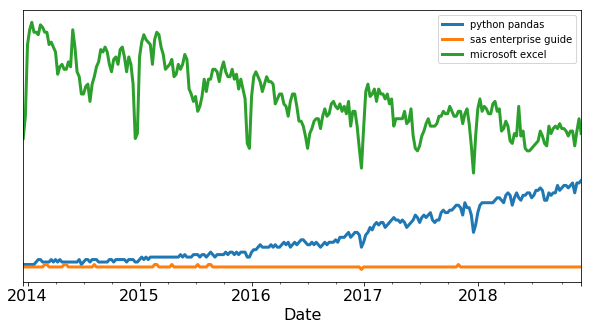

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = df_trends.plot(ax=ax, lw=3, fontsize=16)
ax.set_xlabel('Date', fontsize=16); ax.set_yticks([]);
fig.savefig('pandas_vs_excel_vs_sas.png', dpi=100)

Take mean over the week of the each, looking for a *seasonal component*.

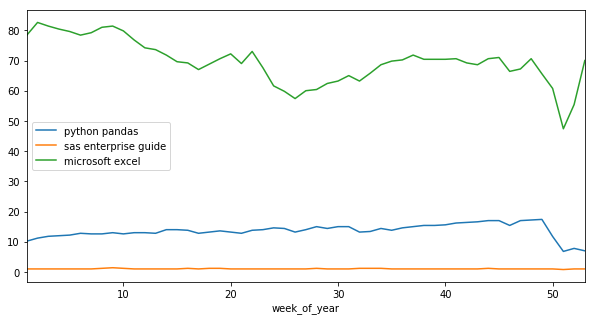

In [42]:
(df_trends
 .assign(week_of_year=lambda df: df.index.to_series().dt.week)
 .groupby('week_of_year')
 .mean()
 .plot(figsize=(10, 5))
);

The same as above, but grouping by **months** instead of **weeks**.

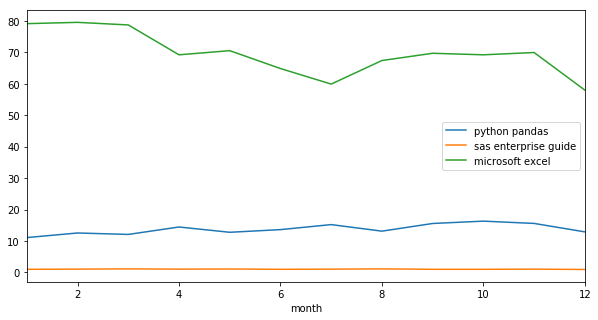

In [43]:
(df_trends
 .assign(month=lambda df: df.index.to_series().dt.month)
 .groupby('month')
 .mean()
 .plot(figsize=(10, 5))
);

## (8.2) Rolling window functions

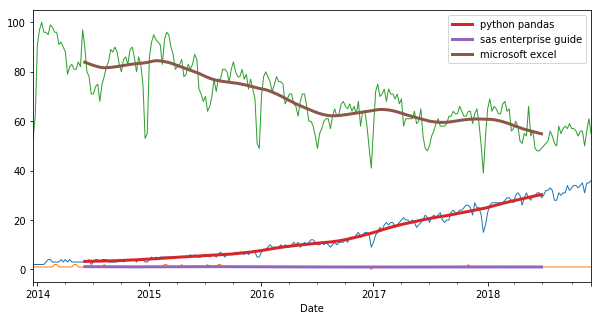

In [44]:
window = 48
fig, ax = plt.subplots(figsize=(10, 5))

# Ploto the original data
ax = df_trends.plot(legend=False, lw=1, ax=ax);

# Ploto the rolling means, using a triangular window
(df_trends
 .rolling(window, win_type='triang', center=True)
 .mean()
 .plot(ax=ax, lw=3)
);

Rolling **average** and **standard deviation**.

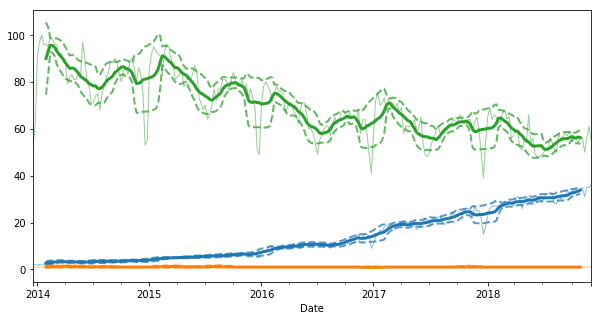

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
window = 12

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for column, color in zip(df_trends.columns, colors):
    ax = df_trends[column].plot(ax=ax, lw=1, color=color, alpha=0.5);
    avg = df_trends[column].rolling(window, center=True).mean()
    
    # Here an aggregation function can be used
    std = df_trends[column].rolling(window, center=True).agg(pd.Series.std)
    ax = avg.plot(ax=ax, lw=3, color=color, alpha=1);
    ax = (avg + std).plot(ax=ax, lw=2, color=color, alpha=0.75, ls='--');
    ax = (avg - std).plot(ax=ax, lw=2, color=color, alpha=0.75, ls='--');

## (8.3) Resampling

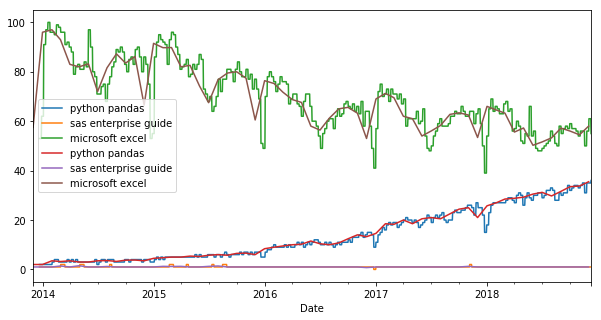

In [46]:
# The original data is weekly. Here we resample to daily and monthly

# Upsample
ax = (df_trends
      .resample('d')
      .pad()
      .plot(figsize=(10, 5))
     )

# Downsample
(df_trends
 .resample('M')
 .mean()
 .plot(ax=ax));

# (9) Modeling and Machine Learning

- How to create *dummy variables* (one-hot-encoding) of categorical data for machine learning algorithms.
- How to use [scikit-learn](https://scikit-learn.org/stable/) with pandas.

In [47]:
# We want pandas to display more columns and rows
pd.set_option('display.max_rows', 2**6)
pd.set_option('display.max_columns', 2**6)

## (9.1) Dummy variables for categorical data

We start by re-loading the data.

In [48]:
# We reload the data
cols_to_use = ['movie_title', 'duration', 'genres', 'content_rating', 'budget', 'gross']
df_model = pd.read_csv(r'data/movie_metadata.csv', sep=',', usecols=cols_to_use)
print(f'Loaded data of size {df_model.shape} into memory.')

Loaded data of size (5043, 6) into memory.


In [49]:
# Drop any row with missing information
df_model = df_model.dropna(axis=0, how='any').drop_duplicates(subset=None)
df_model.shape

(3739, 6)

In [50]:
df_model.sample(5, random_state=3)

,duration,gross,genres,movie_title,content_rating,budget
74,96.0,100289690.0,Comedy|Family|Fantasy,Evan Almighty,PG,175000000.0
1524,138.0,141340178.0,Drama|Thriller,A Few Good Men,R,40000000.0
3032,107.0,50461335.0,Drama|Fantasy|Music|Romance,If I Stay,PG-13,11000000.0
332,126.0,63540020.0,Action|Adventure|Sci-Fi,The Fifth Element,PG-13,93000000.0
1163,122.0,41252428.0,Comedy|Drama|Romance,The Mirror Has Two Faces,PG-13,42000000.0


How to apply one-hot-encoding using `pandas.get_dummies`.

In [51]:
df_model.content_rating.to_frame().sample(3, random_state=3)

,content_rating
74,PG
1524,R
3032,PG-13


In [52]:
dummies = pd.get_dummies(df_model.content_rating)
dummies.sample(3, random_state=3)

,Approved,G,GP,M,NC-17,Not Rated,PG,PG-13,Passed,R,Unrated,X
74,0,0,0,0,0,0,1,0,0,0,0,0
1524,0,0,0,0,0,0,0,0,0,1,0,0
3032,0,0,0,0,0,0,0,1,0,0,0,0


In [53]:
# Merge the dummy variables into the original data set
df_model = df_model.merge(dummies, how='left', left_index=True, right_index=True)
df_model = df_model.drop(columns='content_rating', errors='ignore')
df_model.sample(5, random_state=3)

,duration,gross,genres,movie_title,budget,Approved,G,GP,M,NC-17,Not Rated,PG,PG-13,Passed,R,Unrated,X
74,96.0,100289690.0,Comedy|Family|Fantasy,Evan Almighty,175000000.0,0,0,0,0,0,0,1,0,0,0,0,0
1524,138.0,141340178.0,Drama|Thriller,A Few Good Men,40000000.0,0,0,0,0,0,0,0,0,0,1,0,0
3032,107.0,50461335.0,Drama|Fantasy|Music|Romance,If I Stay,11000000.0,0,0,0,0,0,0,0,1,0,0,0,0
332,126.0,63540020.0,Action|Adventure|Sci-Fi,The Fifth Element,93000000.0,0,0,0,0,0,0,0,1,0,0,0,0
1163,122.0,41252428.0,Comedy|Drama|Romance,The Mirror Has Two Faces,42000000.0,0,0,0,0,0,0,0,1,0,0,0,0


-----------------

Notice now the **genres** column above. Here each row has a variable number of genres.

We now show how to dummy-encode this categorical data.

In [54]:
from functools import reduce

# Split the genres, take the union over every set to get every genre in the data set
genres_sets = df_model.genres.str.split('|').apply(set)
genres = reduce(set.union, genres_sets)
print(genres)

{'Mystery', 'Film-Noir', 'Animation', 'Adventure', 'Documentary', 'Musical', 'Fantasy', 'Western', 'Horror', 'Thriller', 'Family', 'Action', 'Comedy', 'Sport', 'Crime', 'Biography', 'History', 'War', 'Sci-Fi', 'Drama', 'Romance', 'Music'}


In [55]:
# For every genre, add a dummy column
for genre in genres:
    df_model[genre] = np.where(df_model.genres.str.contains(genre), 1, 0)
    
df_model = df_model.drop(columns='genres', errors='ignore')

In [56]:
df_model.head(2)

,duration,gross,movie_title,budget,Approved,G,GP,M,NC-17,Not Rated,PG,PG-13,Passed,R,Unrated,X,Mystery,Film-Noir,Animation,Adventure,Documentary,Musical,Fantasy,Western,Horror,Thriller,Family,Action,Comedy,Sport,Crime,Biography,History,War,Sci-Fi,Drama,Romance,Music
0,178.0,760505847.0,Avatar,237000000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,169.0,309404152.0,Pirates of the Caribbean: At World's End,300000000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## (9.2) Training a model

Let's try to predict $y = \log_{10}(1 + \text{gross})$ based on the other features in the data set.

In [57]:
assert (df_model['gross'] >= 0).all()
assert (df_model['budget'] >= 0).all()

log10plus = lambda x: np.log10(1 + x)

df_model['gross_log'] = df_model['gross'].apply(log10plus)
df_model['budget_log'] = df_model['budget'].apply(log10plus)
df_model = df_model.drop(columns=['gross', 'budget'])

type(X)=<class 'numpy.ndarray'>
type(y)=<class 'pandas.core.series.Series'>


0.9208172135283045

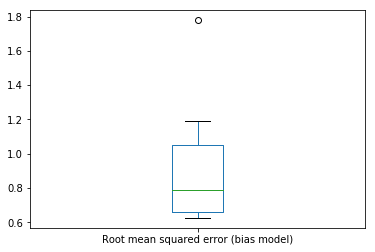

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Here's a very simple model. It only has a bias, so it uses the mean value to predict
X = np.ones((len(df_model), 1))
y = df_model['gross_log']

reg = LinearRegression(fit_intercept=False)

print(f'type(X)={type(X)}')
print(f'type(y)={type(y)}')
scores = -cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
scores = np.sqrt(scores)

pd.Series(scores, name='Root mean squared error (bias model)').plot.box();
np.mean(scores)

Columns used: ['Action', 'Adventure', 'Animation', 'Approved', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'G', 'GP', 'History', 'Horror', 'M', 'Music', 'Musical', 'Mystery', 'NC-17', 'Not Rated', 'PG', 'PG-13', 'Passed', 'R', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Unrated', 'War', 'Western', 'X', 'budget_log', 'duration']


0.7029719639736746

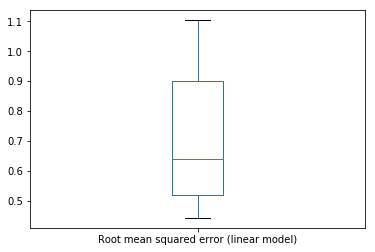

In [59]:
X = df_model.drop(columns=['movie_title', 'gross_log'])
y = df_model.gross_log

print('Columns used:', sorted(X.columns.tolist()))

reg = LinearRegression()

scores = -cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
scores = np.sqrt(scores)

pd.Series(scores, name='Root mean squared error (linear model)').plot.box();
np.mean(scores)

# (10) Misc tips and tricks

## (10.1) Performance

Recall that:
- A millisecond `ms` is $10^{-3}$ seconds (*thousandth*)
- A microsecond `µs` is $10^{-6}$ seconds (*millionth*)
- A nanosecond `ns` is $10^{-9}$ seconds (*billionth*)

 ### Finding the n-largest

There might exists built in methods which are optimal for your use case. Finding the maximum is an $\mathcal{O}(n)$ operation, while sorting is $\mathcal{O}(n \log n)$. Finding the top $k$ rows can be done in $\mathcal{O}(k + n \log k)$ time.

In [60]:
# Create a series with a million entries
ser = pd.Series(np.random.randn(1000000))

In [61]:
(ser.nlargest(50) == ser.sort_values(ascending=False).head(50)).all()

True

In [62]:
%%timeit

[ser.max() for i in range(50)]

219 ms ± 5.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
%%timeit

ser.sort_values(ascending=False).head(50)

192 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
%%timeit

ser.nlargest(50)

14.3 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Filter *before* computing

It's generally better to apply filters *before* computations, especially if the computations are expensive.

In [65]:
%%timeit

df.mean().imdb_score

49.4 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
%%timeit

df.imdb_score.mean()

46 µs ± 288 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Setting a sorted index can speed up filtering 

In [67]:
df = df.sort_values('gross').dropna(how='any')
df_sorted_index = df.set_index('director_name').sort_index()

In [68]:
df_sorted_index.index.dropna().is_monotonic

True

In [69]:
%%timeit

df.loc[lambda df:df.director_name == 'o', :]

721 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [70]:
%%timeit

df_sorted_index.loc[slice('o', None), :]

130 µs ± 352 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Vectorize everything (if you can)

Example with logarithms and `map` vs. `apply`.

In [71]:
import math

temp = df.gross.dropna()

In [72]:
%%timeit

temp.map(math.log)

802 µs ± 3.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [73]:
%%timeit

temp.apply(np.log)

160 µs ± 309 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Another vectorization example

Computing the mean of differences.

In [74]:
import statistics

vector = np.arange(1000000)

In [75]:
%%timeit

# Fast NumPy solution
np.mean(vector[1:] - vector[:-1])

1.64 ms ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [76]:
vector = list(vector)

In [77]:
%%timeit

# Slow pure Python solution
statistics.mean((i - j for (i, j) in zip(vector[1:], vector[:-1])))

719 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


> **Note.** Learn more about the joys of vectorization in [From Python to Numpy](https://www.labri.fr/perso/nrougier/from-python-to-numpy/).

### Vectorizing equality checks

In [78]:
df_countries = df.country.sample(5_000_000, replace=True).to_frame().reset_index(drop=True)
df_countries.head(3)

,country
0,USA
1,USA
2,USA


In [79]:
%%timeit

df_countries.assign(USA=lambda df:np.where(df.country == 'USA', 1, 0))

317 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
%%timeit

def is_USA(string):
    if string == 'USA':
        return 1
    return 0

df_countries.assign(USA=lambda df:df.country.apply(is_USA))

1.33 s ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## (10.2) Exporting data

In [81]:
# Save data as a .csv file
df.to_csv(path_or_buf='movies_data_saved.csv', index=False)

In [82]:
# Save data as an Excel file
df.to_excel(excel_writer='movies_data_saved.xlsx', index=False)

In [83]:
# Generate LaTeX code
print(df.head().to_latex(index=False))

\begin{tabular}{lrlllr}
\toprule
         director\_name &   gross &                 movie\_title &   country & content\_rating &  imdb\_score \\
\midrule
   Ekachai Uekrongtham &   162.0 &                 Skin Trade  &  Thailand &              R &         5.7 \\
          Frank Whaley &   703.0 &             The Jimmy Show  &       USA &              R &         5.4 \\
 Brian Trenchard-Smith &   721.0 &        In Her Line of Fire  &   Germany &              R &         4.1 \\
        Ian Fitzgibbon &   828.0 &           Perrier's Bounty  &   Ireland &              R &         6.4 \\
           Ricki Stern &  1111.0 &  The Trials of Darryl Hunt  &       USA &          PG-13 &         7.7 \\
\bottomrule
\end{tabular}



In [84]:
from IPython.core.display import display, HTML

display(HTML(df.head().to_html(index=False)))

director_name,gross,movie_title,country,content_rating,imdb_score
Ekachai Uekrongtham,162.0,Skin Trade,Thailand,R,5.7
Frank Whaley,703.0,The Jimmy Show,USA,R,5.4
Brian Trenchard-Smith,721.0,In Her Line of Fire,Germany,R,4.1
Ian Fitzgibbon,828.0,Perrier's Bounty,Ireland,R,6.4
Ricki Stern,1111.0,The Trials of Darryl Hunt,USA,PG-13,7.7


In [85]:
print(df.head(1).to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>director_name</th>
      <th>gross</th>
      <th>movie_title</th>
      <th>country</th>
      <th>content_rating</th>
      <th>imdb_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Ekachai Uekrongtham</td>
      <td>162.0</td>
      <td>Skin Trade</td>
      <td>Thailand</td>
      <td>R</td>
      <td>5.7</td>
    </tr>
  </tbody>
</table>


In [86]:
# Can write directly to databases

# df.to_sql()

# Resources

- [Official Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/index.html)
- Videos at [awesome-pandas](https://github.com/tommyod/awesome-pandas), especially
- [pandas_exercises](https://github.com/guipsamora/pandas_exercises) repository if you want practice